In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


In [4]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
parking_area,56897,9500.0
parking_price,46065,7710.0
txn_floor,15902,2639.0
village_income_median,1142,184.0


In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))
    
# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [6]:
train_labels = train.pop('total_price')
features = pd.concat([train, test], keys=['train', 'test'])
features.drop(['lat', 'lon', 'doc_rate', 'elementary_rate','txn_floor'],
              axis=1, inplace=True)

In [7]:
# parking NA means no parking space.
for col in ('parking_area','parking_price'):
    features[col] = features[col].fillna(0)
    
# village_income_median NA. Filling with most popular values
features['village_income_median'] = features['village_income_median'].fillna(features['village_income_median'].mode()[0])

# Change the features to categorical
features['building_material'] = features['building_material'].astype(str)
features['city'] = features['city'].astype(str)
features['town'] = features['town'].astype(str)
features['building_type'] = features['building_type'].astype(str)
features['building_use'] = features['building_use'].astype(str)
features['parking_way'] = features['parking_way'].astype(str)
for feature in features:
    if 'index' in feature:
        features[feature] = features[feature].astype(str)
        




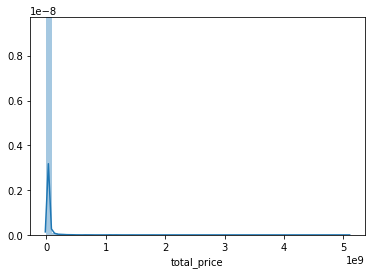

In [8]:
ax = sns.distplot(train_labels)

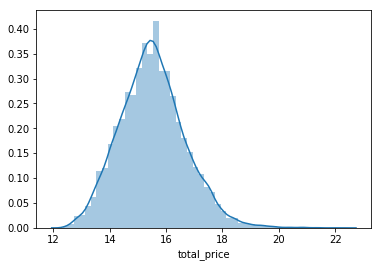

In [9]:
# Do log transformation of labels.
train_labels = np.log(train_labels)
ax = sns.distplot(train_labels)

In [11]:
building_materials = set([x for x in features['building_material']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(building_materials))),
                       index=features.index, columns=building_materials)

for col in features.dtypes[features.dtypes == 'object'].index:
    print(col)

building_id
building_material
city
building_type
building_use
parking_way
town
I_index_50
I_index_500
I_index_1000
I_index_5000
I_index_10000
II_index_50
II_index_500
II_index_1000
II_index_5000
II_index_10000
III_index_50
III_index_500
III_index_1000
III_index_5000
III_index_10000
IV_index_50
IV_index_500
IV_index_1000
IV_index_5000
IV_index_10000
V_index_50
V_index_500
V_index_1000
V_index_5000
V_index_10000
VI_index_50
VI_index_500
VI_index_1000
VI_index_5000
VI_index_10000
VII_index_50
VII_index_500
VII_index_1000
VII_index_5000
VII_index_10000
VIII_index_50
VIII_index_500
VIII_index_1000
VIII_index_5000
VIII_index_10000
IX_index_50
IX_index_500
IX_index_1000
IX_index_5000
IX_index_10000
X_index_50
X_index_500
X_index_1000
X_index_5000
X_index_10000
XI_index_50
XI_index_500
XI_index_1000
XI_index_5000
XI_index_10000
XII_index_50
XII_index_500
XII_index_1000
XII_index_5000
XII_index_10000
XIII_index_50
XIII_index_500
XIII_index_1000
XIII_index_5000
XIII_index_10000
XIV_index_50
XIV_

In [68]:
numeric_features = features.loc[:,['total_floor','txn_dt','building_complete_dt','parking_area','parking_price','land_area','building_area',
                                    'village_income_median','town_population','town_area','town_population_density','master_rate','bachelor_rate','highschool_rate','jobschool_rate','junior_rate','born_rate','death_rate',
                                    'marriage_rate','divorce_rate']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

In [69]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [70]:
### Splitting features
train_features = features.loc['train'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values

In [71]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [72]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [73]:
# ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
# train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

In [74]:
# # Average R2 score and standart deviation of 5-fold cross-validation
# scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [75]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
R2: 0.9593905927121644
RMSE: 0.22947479981982094
Test
R2: 0.9552344582374395
RMSE: 0.23894813641629034


In [76]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.95 (+/- 0.00)


In [77]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
# ENST_model = ENSTest.fit(train_features_st, train_labels)

In [80]:
## Getting our SalePrice estimation
# Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2
Final_labels = (np.exp(GB_model.predict(test_features)))

In [81]:
## Saving to CSV
pd.DataFrame({'building_id': test.building_id, 'total_price': Final_labels}).to_csv('2019-06-15.csv', index =False) 